Classify the quarupole model with indices (qxy,qyx)

# Import some stuff

In [9]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

# Get training data

In [10]:
# This is to generate the hamiltonian without perturbations
# To do: Change the representations in a random way 

import numpy as np

def quadmodel_generator(N=32):
    
#     g1 = - np.kron([[0, -1j], [1j, 0]], [[0, 1], [1, 0]])
#     g2 = - np.kron([[0, -1j], [1j, 0]], [[0, -1j], [1j, 0]])
#     g3 = - np.kron([[0, -1j], [1j, 0]], [[1, 0], [0, -1]])
#     g4 = np.kron([[0, 1], [1, 0]], np.eye(2))
    
    s0 = [ [1,0] , [0,1] ] 
    s1 = [ [0,1] , [1,0] ]
    s2 = [ [0,-1j] , [1j , 0] ]
    s3 = [ [1,0] , [0,-1] ]
    s = np.array( [s0,s1,s2,s3] ) 

    ind = int( rand() *3 + 1 ) 
    ind2 = np.setdiff1d( [1,2,3] , ind )

    g1 = -np.kron( s[ind] , s[1] ) 
    g2 = -np.kron( s[ind] , s[2] ) 
    g3 = -np.kron( s[ind] , s[3] ) 
    g4 = np.kron( s[int(ind2[[0]])] , s[0] ) 
    g5 = np.kron( s[int(ind2[[1]])] , s[0] ) 

    g = np.array( [ g1 , g2 , g3 , g4 , g5 ] ) 

    GG = np.zeros(g.shape,dtype=complex)
    ind3 = np.random.permutation(5)
    #     print(ind3)
    for i in range(5):
        GG[i] = g[ind3[i]]

    # GGtrace = np.zeros((4,4),dtype=complex)
    # for ii in range(4):
    #     for jj in range(4):
    #         GGtrace[ii,jj] = np.trace( np.dot( GG[ii] , GG[jj] ) + np.dot( GG[jj] , GG[ii] ) )
    # print( GGtrace ) 

    g1 = GG[0]
    g2 = GG[1]
    g3 = GG[2]
    g4 = GG[3]
    
    
    kr = np.linspace(0, 2 * np.pi, N)
    kx, ky = np.meshgrid(kr, kr) # row corresponds to y, column corresponds to x
    while True:
        coef = np.random.uniform(-1.5, 1.5, 2) # coupling lx, ly between [-2, 2]
        h = (np.kron((coef[0] + np.cos(kx)), g4.flatten()) + np.kron(np.sin(kx), g3.flatten()) + 
             np.kron((coef[1] + np.cos(ky)), g2.flatten()) + np.kron(np.sin(ky), g1.flatten())).reshape((N, N, 16))
        hr, hi = np.real(h), np.imag(h)
        h_tot = np.concatenate((hr, hi), axis = 2) # h_tot has dimension (dim_kx, dim_ky, 16*2)    
        if abs(coef[0]) < 1 and abs(coef[1]) < 1:
            qxy = 1
            qyx = 1
        elif abs(coef[0]) < 1 and abs(coef[1]) > 1 :
            qxy = 1
            qyx = 0
        elif abs(coef[0]) > 1 and abs(coef[1]) < 1 :
            qxy = 0 
            qyx = 1
        elif abs(coef[0]) > 1 and abs(coef[1]) > 1 :
            qxy = 0
            qyx = 0
        
        target = np.zeros((1,2))
        target[0,0] = qxy 
        target[0,1] = qyx
        
#         target = [[qxy],[qyx]]   
        
        
        yield h_tot, target
        

def generate_data(sample_size, dim_k):
    data = np.zeros((sample_size, dim_k, dim_k, 32))
    target = np.zeros((sample_size,2))
    gen = quadmodel_generator(dim_k)
    for i in range(sample_size):
        data[i, :], target[i,:] = next(gen)
    return data, target 


train_size = 10 ** 3
test_size = 10 ** 3

num_k = 32 + 1

X_train, y_train = generate_data(train_size, num_k)
X_test, y_test = generate_data(test_size, num_k) 
np.savez('quad_data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

# sns.distplot(y_train)
             

# Build a CNN

In [11]:
from keras import layers
from keras import models

model_cnn = models.Sequential()
model_cnn.add( layers.Conv2D( 8 , (3,3) , activation = 'relu' , input_shape = (num_k, num_k, 32) ) ) 
model_cnn.add( layers.MaxPooling2D( (2,2) ) ) 
model_cnn.add( layers.Conv2D( 4 , (3,3) , activation = 'relu' ) ) 
# model_cnn.add( layers.MaxPooling2D( (2,2) ) ) 
# model_cnn.add( layers.Conv2D( 8 , (3,3) , activation = 'relu' ) ) 
# model_cnn.add( layers.MaxPooling2D( (2,2) ) ) 

model_cnn.add( layers.Flatten())
model_cnn.add( layers.Dense(4, activation='relu'))
model_cnn.add( layers.Dense(2, activation='softmax'))

model_cnn.summary()




Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 31, 8)         2312      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 4)         292       
_________________________________________________________________
flatten_3 (Flatten)          (None, 676)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 2708      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 10        
Total params: 5,322
Trainable params: 5,322
Non-trainable params: 0
____________________________________________________

Epoch 1/40
1000/1000 [==============================] - 1s 1ms/step - loss: 0.9203 - mae: 0.4435
Epoch 2/40
1000/1000 [==============================] - 1s 831us/step - loss: 1.4153 - mae: 0.4381
Epoch 3/40
1000/1000 [==============================] - 1s 819us/step - loss: 2.2278 - mae: 0.4321
Epoch 4/40
1000/1000 [==============================] - 1s 788us/step - loss: 4.1533 - mae: 0.4638
Epoch 5/40
1000/1000 [==============================] - 1s 978us/step - loss: 6.9660 - mae: 0.4751
Epoch 6/40
1000/1000 [==============================] - 1s 794us/step - loss: 10.6618 - mae: 0.4567
Epoch 7/40
1000/1000 [==============================] - 1s 801us/step - loss: 15.7963 - mae: 0.4705
Epoch 8/40
1000/1000 [==============================] - 1s 1ms/step - loss: 21.6874 - mae: 0.4680
Epoch 9/40
1000/1000 [==============================] - 1s 874us/step - loss: 27.8004 - mae: 0.4894
Epoch 10/40
1000/1000 [==============================] - 1s 883us/step - loss: 37.3721 - mae: 0.4675
Epoch 11

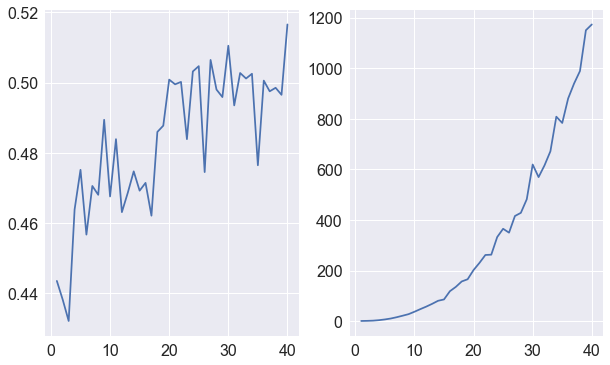

In [8]:
batch_size = 50
num_epochs = 40
model_cnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['mae'])
history_cnn = model_cnn.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs)

model_cnn.save('quad_cnn_model1_2classes.h5')

mae_cnn = history_cnn.history['mae']
# acc_cnn = history_cnn.history['accuracy']
loss_cnn = history_cnn.history['loss']

epochs = range(1, len(mae_cnn) + 1)
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].plot(epochs, mae_cnn)
# axes[0].plot(epochs, acc_cnn)
axes[1].plot(epochs, loss_cnn)


# Apply to test data